In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pickle import dump

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv')
df

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,43051,6104,14.178532,6326,14.694200,5359,12.448027,6577,15.277229,...,2098,8.9,8.3,9.6,2834,2.6,2.4,2.8,821,5
3136,56039,23081,2384,10.328842,2185,9.466661,2967,12.854729,4093,17.733200,...,928,7.2,6.5,8.0,1360,2.4,2.2,2.6,447,5
3137,56041,20299,3121,15.375142,3205,15.788955,2153,10.606434,2702,13.311001,...,1163,10.4,9.5,11.2,1500,3.0,2.8,3.2,430,5
3138,56043,7885,858,10.881420,1113,14.115409,715,9.067850,903,11.452124,...,506,11.3,10.3,12.1,686,3.4,3.2,3.7,207,6


In [3]:
# Eliminar duplicados
df = df.drop_duplicates().reset_index(drop=True)

In [4]:
df.isnull().sum().sort_values(ascending=False)

fips                                0
Total nurse practitioners (2019)    0
STATE_NAME                          0
COUNTY_NAME                         0
Percent of Population Aged 60+      0
                                   ..
POP_ESTIMATE_2018                   0
% Two or more races                 0
Two or more races pop               0
% Hawaiian/PI-alone                 0
Urban_rural_code                    0
Length: 108, dtype: int64

In [5]:
# Identificar variables categóricas y numéricas
tipos_datos = df.dtypes
col_no_numericas = [c for c in list(tipos_datos[tipos_datos == object].index)]
col_numericas = [c for c in list(tipos_datos[tipos_datos != object].index) if c != 'Obesity_number']

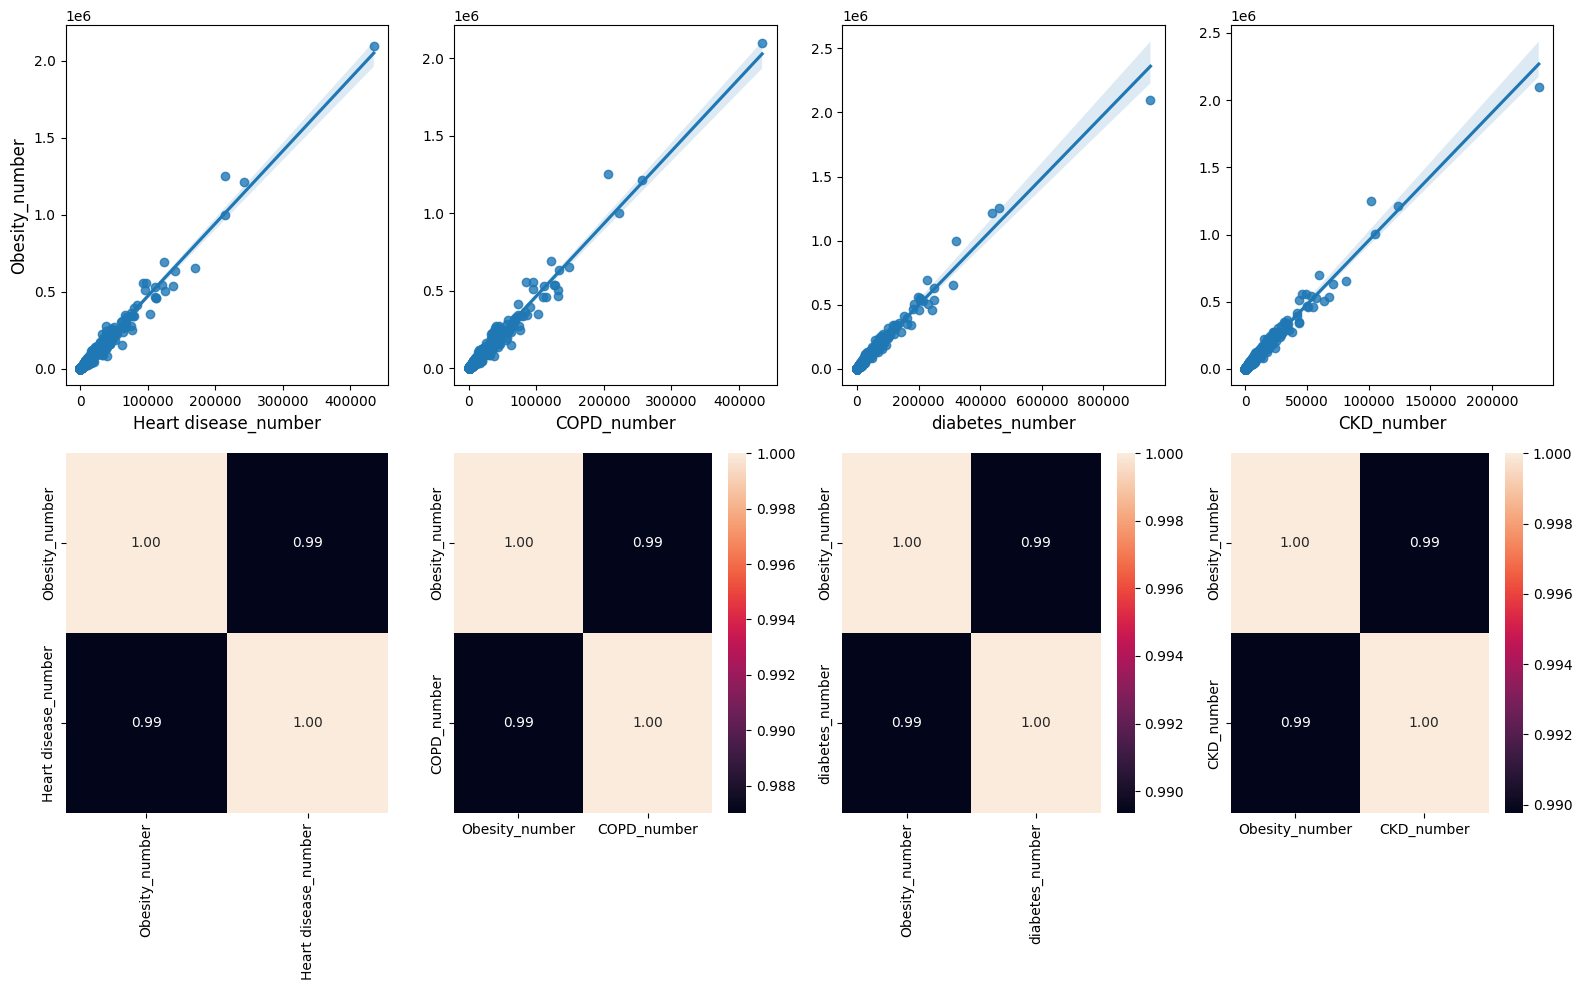

In [6]:
# Visualización de datos
fig, axis = plt.subplots(2, 4, figsize=(16, 10))
sns.regplot(ax=axis[0, 0], data=df, x="Heart disease_number", y="Obesity_number")
sns.heatmap(df[["Obesity_number", "Heart disease_number"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)
sns.regplot(ax=axis[0, 1], data=df, x="COPD_number", y="Obesity_number").set(ylabel=None)
sns.heatmap(df[["Obesity_number", "COPD_number"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])
sns.regplot(ax=axis[0, 2], data=df, x="diabetes_number", y="Obesity_number").set(ylabel=None)
sns.heatmap(df[["Obesity_number", "diabetes_number"]].corr(), annot=True, fmt=".2f", ax=axis[1, 2])
sns.regplot(ax=axis[0, 3], data=df, x="CKD_number", y="Obesity_number").set(ylabel=None)
sns.heatmap(df[["Obesity_number", "CKD_number"]].corr(), annot=True, fmt=".2f", ax=axis[1, 3])
for ax in axis.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
# Normalización
scaler = StandardScaler()
col_normalizadas = scaler.fit_transform(df[col_numericas])
df_normalizado = pd.DataFrame(col_normalizadas, index=df.index, columns=col_numericas)

In [8]:
# División en train y test
X = df_normalizado
y = df['Obesity_number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Modelo de Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print(f'Intercepto: {model_lr.intercept_}')
print(f'Coeficientes: {model_lr.coef_}')
print(f'MSE: {mean_squared_error(y_test, y_pred_lr)}')
print(f'R2: {r2_score(y_test, y_pred_lr)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lr)}')

Intercepto: 25281.260872254425
Coeficientes: [-2.01705005e+11 -1.05260080e+15  4.15489512e+14 -1.49176292e+10
  4.20230933e+14 -1.27472322e+10  4.92713570e+14 -2.19562851e+10
  4.86882093e+14 -1.19153769e+10  4.32035511e+14 -9.64225274e+09
  4.24566348e+14 -1.04060655e+10  3.43052723e+14 -1.77859760e+10
  2.01621307e+14 -1.55555646e+10  1.19892334e+14 -1.07806513e+10
  2.95613437e+14 -2.66725295e+11  7.34995455e+13 -2.36205896e+11
  6.68047237e+12 -1.25980280e+11  5.46756454e+13 -4.66119119e+10
  2.73089281e+12 -1.57915429e+10  1.38083528e+13 -2.51971161e+10
 -2.67819736e+15 -2.12762500e+03 -8.52593750e+02  8.99000000e+02
 -1.07362500e+03 -1.46285938e+03  2.67231250e+03  1.44584844e+04
 -1.42699531e+04 -3.93696875e+03 -2.57000000e+02 -1.27203750e+04
 -9.72191016e+03 -2.88940625e+03 -3.43981250e+03 -2.17400000e+03
 -4.27119531e+03 -4.40818750e+03  2.04660156e+02 -4.29750000e+02
  6.91000000e+02  1.22255473e+15 -9.55693495e+14 -1.00667394e+15
  1.29094851e+15 -1.23869125e+15 -5.33169878e

In [10]:
# Modelo Lineal Regularizado de Lasso
model_lasso = Lasso(alpha=1.0, max_iter=100)
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred_lasso)}')
print(f'R2: {r2_score(y_test, y_pred_lasso)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lasso)}')

MSE: 17404106.685237333
R2: 0.9920405204000391
MAE: 1696.6214301223945


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+10, tolerance: 1.602e+09
  model = cd_fast.enet_coordinate_descent(


In [11]:
# Optimización de hiperparámetros para Lasso
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_lasso = GridSearchCV(Lasso(max_iter=100), param_grid, cv=5)
grid_lasso.fit(X_train, y_train)
print(f'Best Lasso alpha: {grid_lasso.best_params_["alpha"]}')
model_lasso2 = grid_lasso.best_estimator_
y_pred_lasso2 = model_lasso2.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred_lasso2)}')
print(f'R2: {r2_score(y_test, y_pred_lasso2)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lasso2)}')

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+10, tolerance: 1.389e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+10, tolerance: 1.408e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best Lasso alpha: 100.0
MSE: 16509585.8066171
R2: 0.9924496146910524
MAE: 1496.8725293548603


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e+10, tolerance: 9.483e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.708e+10, tolerance: 1.602e+09
  model = cd_fast.enet_coordinate_descent(


In [12]:
# Modelo Lineal Regularizado de Ridge
model_ridge = Ridge(alpha=1.0, max_iter=100)
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred_ridge)}')
print(f'R2: {r2_score(y_test, y_pred_ridge)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_ridge)}')

MSE: 4769255.53221656
R2: 0.997818860065488
MAE: 949.4455504119326


In [13]:
# Comparación de modelos
print("Modelo de Regresión Lineal:")
print(f'MSE: {mean_squared_error(y_test, y_pred_lr)}')
print(f'R2: {r2_score(y_test, y_pred_lr)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lr)}')

print("\nModelo Lasso:")
print(f'MSE: {mean_squared_error(y_test, y_pred_lasso)}')
print(f'R2: {r2_score(y_test, y_pred_lasso)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lasso)}')

print("\nMejora de modelo Lasso:")
print(f'Best Lasso alpha: {grid_lasso.best_params_["alpha"]}')
print(f'MSE: {mean_squared_error(y_test, y_pred_lasso2)}')
print(f'R2: {r2_score(y_test, y_pred_lasso2)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_lasso2)}')

print("\nModelo Ridge:")
print(f'MSE: {mean_squared_error(y_test, y_pred_ridge)}')
print(f'R2: {r2_score(y_test, y_pred_ridge)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_ridge)}')

Modelo de Regresión Lineal:
MSE: 4255410.136382322
R2: 0.9980538587367582
MAE: 963.2624572149502

Modelo Lasso:
MSE: 17404106.685237333
R2: 0.9920405204000391
MAE: 1696.6214301223945

Mejora de modelo Lasso:
Best Lasso alpha: 100.0
MSE: 16509585.8066171
R2: 0.9924496146910524
MAE: 1496.8725293548603

Modelo Ridge:
MSE: 4769255.53221656
R2: 0.997818860065488
MAE: 949.4455504119326


In [14]:
from pickle import dump

# Guardar el modelo de regresión lineal
dump(model_lr, open("modelo_regresion_lineal.sav", "wb"))
print("Modelo de regresión lineal guardado correctamente.")

# Guardar el modelo Lasso
dump(model_lasso, open("modelo_lasso.sav", "wb"))
print("Modelo Lasso guardado correctamente.")

# Guardar el modelo Lasso con la mejora
dump(model_lasso2, open("modelo_lasso_mejorado.sav", "wb"))
print("Mejora de modelo Lasso guardada correctamente.")

# Guardar el modelo de Ridge
dump(model_ridge, open("modelo_ridge.sav", "wb"))
print("Modelo de Ridge guardado correctamente.")

Modelo de regresión lineal guardado correctamente.
Modelo Lasso guardado correctamente.
Mejora de modelo Lasso guardada correctamente.
Modelo de Ridge guardado correctamente.
